# Def2Vec

## Environment preparation

### Imports

In [1]:
import os
import yaml

In [2]:
from itertools import product
from collections import Counter

In [3]:
from tqdm import tqdm

In [4]:
import hashlib

In [5]:
import numpy as np

In [6]:
import pandas as pd

In [7]:
from joblib import Parallel, delayed, parallel_backend

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [9]:
from vstk.models import Def2Vec

/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
from vstk.tokenisers import NLTKTokeniser

In [11]:
from vstk.data import CoNLL2003, SST, STS, NewsGroups, WELFake

### Constants

In [12]:
MODEL_DIR_PATH = '../resources/models/pre_trained'

In [13]:
CONLL2003_DATA_PATH = '../resources/data/raw/conll2003'
SST_DATA_PATH = '../resources/data/raw/stanfordSentimentTreebank'
STS_DATA_PATH = '../resources/data/raw/stsbenchmark'
WELFAKE_DATA_PATH = '../resources/data/raw/WELFake'
WIKTIONARY_DATA_PATH = '../resources/data/raw/wiktionary/en/dump_irene/word_def_dictionary.csv'

In [14]:
if not os.path.exists('../resources/'):
    os.mkdir('../resources/')
if not os.path.exists('../resources/models'):
    os.mkdir('../resources/models')

### Global

In [15]:
df = pd.read_csv(WIKTIONARY_DATA_PATH, dtype=str)
# TODO find better solution
tmp_df = df[df.isna().any(axis=1)]
df = pd.concat([df[~df.isna().any(axis=1)], pd.DataFrame.from_dict([{'title': 'nan', 'text': '\n\n'.join(tmp_df['text'])}])], axis=0)
df.head(10)

,title,text
0,dictionary,( by extension ) any work that has a list of m...
1,free,not imprisoned or enslaved .\n\nunconstrained ...
2,thesaurus,( archaic ) a dictionary or encyclopedia .\n\n...
3,encyclopedia,( dated ) the circle of arts and sciences ; a ...
4,portmanteau,a large travelling case usually made of leathe...
5,encyclopaedia,"( chiefly , uk , australia ) alternative spell..."
6,cat,an animal of the family <unk> :\n\na person :\...
7,gratis,"free , without charge .\n\nfree , without char..."
8,word,the smallest discrete unit of spoken language ...
9,livre,( historical ) a unit of currency formerly use...


In [16]:
tokeniser = NLTKTokeniser()

In [17]:
conll2003 = {split: CoNLL2003(CONLL2003_DATA_PATH, split=split) for split in ['train', 'validation', 'test']}
sst = {split: SST(SST_DATA_PATH, split=split) for split in ['train', 'validation', 'test']}
sts = {split: STS(STS_DATA_PATH, split=split) for split in ['train', 'validation', 'test']}
ng = {split: NewsGroups(split=split) for split in ['train', 'validation', 'test']}
welfake = {split: WELFake(WELFAKE_DATA_PATH, split=split) for split in ['train', 'validation', 'test']}

### Helper functions

In [18]:
def get_configs_hash(**configs):
    return hashlib.sha256(str(configs).encode()).hexdigest()

## Def2Vec

### Data set analysis

In [19]:
with parallel_backend('threading', n_jobs=-1):  # , verbose=2):
    wiktionary_data = [
        token
        for sample in Parallel()(
            delayed(lambda x: tokeniser(f'{x['title']}\n\n{x['text']}'))(row) 
            for _, row in df.iterrows()
        )
        for token in sample
    ]
    print(f'Tokens in Wiktionary data: {len(wiktionary_data)}')
    conll2003_data = [elem['token'] for split in conll2003 for sample in conll2003[split] for elem in sample]
    print(f'Tokens in CoNLL data: {len(conll2003_data)}')
    sst_data = [
        token
        for sample in Parallel()(
            delayed(lambda x: tokeniser(x['sequence']))(elem) 
            for split in sst for elem in sst[split]
        )
        for token in sample
    ]
    print(f'Tokens in Stanford Sentiment Treebank data: {len(sst_data)}')
    sts_data = [
        token
        for sample in Parallel()(
            delayed(lambda x, y: tokeniser(x[f'sequence_{y}']))(elem, i) 
            for split in sts for elem in sts[split] for i in 'ab'
        )
        for token in sample
    ]
    print(f'Tokens in Semantic Textual Similarity data: {len(sts_data)}')
    ng_data = [
        token
        for sample in Parallel()(
            delayed(lambda x: tokeniser(x['sequence']))(elem) 
            for split in ng for elem in ng[split]
        )
        for token in sample
    ]
    print(f'Tokens in 20 News Groups data: {len(sst_data)}')
    welfake_data = [
        token
        for sample in Parallel()(
            delayed(lambda x: tokeniser(x['sequence']))(elem) 
            for split in welfake for elem in welfake[split]
        )
        for token in sample
    ]
    print(f'Tokens in WELFake data: {len(sst_data)}')

Tokens in Wiktionary data: 10569365
Tokens in CoNLL data: 301418
Tokens in Stanford Sentiment Treebank data: 220353
Tokens in Semantic Textual Similarity data: 197467
Tokens in 20 News Groups data: 220353
Tokens in WELFake data: 220353


In [20]:
counts = Counter(token.lower() for token in wiktionary_data)

In [21]:
frequent_words_wiktionary = set(token.lower() for token, count in counts.items() if count > 10)
infrequent_words_conll2003 = set(conll2003_data) - frequent_words_wiktionary
infrequent_words_sst = set(sst_data) - frequent_words_wiktionary
infrequent_words_sts = set(sts_data) - frequent_words_wiktionary
infrequent_words_ng = set(ng_data) - frequent_words_wiktionary
infrequent_words_welfake = set(welfake_data) - frequent_words_wiktionary

In [22]:
words_to_restore = infrequent_words_conll2003 | infrequent_words_sst | infrequent_words_sts

In [23]:
wiktionary_data_reduced = df[df['title'].apply(lambda x: x.lower()).isin(frequent_words_wiktionary)]
wiktionary_data_to_restore = df[df['title'].apply(lambda x: x.lower()).isin(words_to_restore)]

In [24]:
print(f'Wiktionary entries: {len(df)}')
print(f'Wiktionary tokens: {len(wiktionary_data)}')
print(f'Frequent Wiktionary tokens: {len(wiktionary_data_reduced)}')

Wiktionary entries: 764593
Wiktionary tokens: 10569365
Frequent Wiktionary tokens: 30173


### Data stats

In [25]:
for name, data in zip(['conll2003', 'sst', 'sts', 'ng', 'welfake'], [conll2003, sst, sts, ng, welfake]):
    print(name)
    for split, samples in data.items():
        print('\t', split, len(samples))

conll2003
	 train 14041
	 validation 3250
	 test 3453
sst
	 train 8117
	 validation 2125
	 test 1044
sts
	 train 5749
	 validation 1500
	 test 1379
ng
	 train 8485
	 validation 2829
	 test 7532
welfake
	 train 40575
	 validation 13525
	 test 18034


In [26]:
import numpy as np

with parallel_backend('threading', n_jobs=-1):  # , verbose=2):
    print('conll2003')
    for split, data in conll2003.items():
        print('\t', split, np.mean([len(sample) for sample in data]))
    print('sst')
    for split, data in sst.items():
        print('\t', split, np.mean(
            Parallel()(
                delayed(lambda x: len(tokeniser(x['sequence'])))(sample) 
                for sample in data
            )))
    print('sts')
    for split, data in sts.items():
        print('\t', split, np.mean(
            Parallel()(
                delayed(lambda x, y: len(tokeniser(x[f'sequence_{y}'])))(sample, key) 
                for sample in data for key in 'ab'
            )))
    print('ng')
    for split, data in ng.items():
        print('\t', split, np.mean(
            Parallel()(
                delayed(lambda x: len(tokeniser(x['sequence'])))(sample) 
                for sample in data
            )))
    print('welfake')
    for split, data in welfake.items():
        print('\t', split, np.mean(
            Parallel()(
                delayed(lambda x: len(tokeniser(x['sequence'])))(sample) 
                for sample in data
            )))

conll2003
	 train 14.501887329962253
	 validation 15.803692307692307
	 test 13.447726614538082
sst
	 train 19.614759147468277
	 validation 19.248
	 test 19.385057471264368
sts
	 train 11.130979300747956
	 validation 12.940333333333333
	 test 11.117476432197245
ng
	 train 423.5013553329405
	 validation 423.1106398020502
	 test 379.8791821561338
welfake
	 train 633.2336906962415
	 validation 625.9621441774492
	 test 634.4147166463347


In [27]:
with parallel_backend('threading', n_jobs=-1):  # , verbose=2):
    print('conll2003')
    for split, data in conll2003.items():
        print('\t', split, len(set([elem['token'].lower() for sample in data for elem in sample])))
    print('sst')
    for split, data in sst.items():
        print('\t', split, len(set(
            tok.lower() for s in Parallel()(
                delayed(lambda x: tokeniser(x['sequence']))(sample) 
                for sample in data
            ) for tok in s
        )))
    print('sts')
    for split, data in sts.items():
        print('\t', split, len(set(
            tok.lower() for s in Parallel()(
                delayed(lambda x, y: tokeniser(x[f'sequence_{y}']))(sample, key) 
                for sample in data for key in 'ab'
            ) for tok in s
        )))
    print('ng')
    for split, data in ng.items():
        print('\t', split, len(set(
            tok.lower() for s in Parallel()(
                delayed(lambda x: tokeniser(x['sequence']))(sample) 
                for sample in data
            ) for tok in s
        )))
    print('welfake')
    for split, data in welfake.items():
        print('\t', split, len(set(
            tok.lower() for s in Parallel()(
                delayed(lambda x: tokeniser(x['sequence']))(sample) 
                for sample in data
            ) for tok in s
        )))

conll2003
	 train 21009
	 validation 9002
	 test 8548
sst
	 train 16310
	 validation 7715
	 test 4856
sts
	 train 12467
	 validation 6567
	 test 4882
ng
	 train 153377
	 validation 69653
	 test 120763
welfake
	 train 291389
	 validation 147835
	 test 178648


In [28]:
infrequent_words_wiktionary = set(token.lower() for token in counts) - frequent_words_wiktionary

with parallel_backend('threading', n_jobs=-1):  # , verbose=2):
    print('conll2003')
    for split, data in conll2003.items():
        tmp = sum(any(elem['token'].lower() in infrequent_words_wiktionary for elem in sample) for sample in data)
        print('\t', split, tmp / len(data))
    print('sst')
    for split, data in sst.items():
        tmp = sum(
            Parallel()(
                delayed(lambda x: any(elem.lower() in infrequent_words_wiktionary for elem in tokeniser(x['sequence'])))(sample) 
                for sample in data
            )
        )
        print('\t', split, tmp / len(data))
    print('sts')
    for split, data in sts.items():
        tmp = sum(
            Parallel()(
                delayed(lambda x: any(elem.lower() in infrequent_words_wiktionary for key in 'ab' for elem in tokeniser(x[f'sequence_{key}'])))(sample) 
                for sample in data
            )
        )
        print('\t', split, tmp / len(data))
    print('ng')
    for split, data in ng.items():
        tmp = sum(
            Parallel()(
                delayed(lambda x: any(elem.lower() in infrequent_words_wiktionary for elem in tokeniser(x['sequence'])))(sample) 
                for sample in data
            )
        )
        print('\t', split, tmp / len(data))
    print('welfake')
    for split, data in welfake.items():
        tmp = sum(
            Parallel()(
                delayed(lambda x: any(elem.lower() in infrequent_words_wiktionary for elem in tokeniser(x['sequence'])))(sample) 
                for sample in data
            )
        )
        print('\t', split, tmp / len(data))

conll2003
	 train 0.5929777081404458
	 validation 0.5941538461538461
	 test 0.5676223573704026
sst
	 train 0.6862141185166933
	 validation 0.6804705882352942
	 test 0.6973180076628352
sts
	 train 0.5289615585319186
	 validation 0.48133333333333334
	 test 0.37055837563451777
ng
	 train 0.9967000589275191
	 validation 0.9936373276776246
	 test 0.9965480616038237
welfake
	 train 0.9939864448552064
	 validation 0.9933456561922366
	 test 0.9931240989242542


In [29]:
with parallel_backend('threading', n_jobs=-1):  # , verbose=2):
    print('conll2003')
    for split, data in conll2003.items():
        tmp = set([elem['token'].lower() for sample in data for elem in sample])
        print('\t', split, len(tmp - frequent_words_wiktionary) / len(tmp))
    print('sst')
    for split, data in sst.items():
        tmp = set(
            tok.lower() for s in Parallel()(
                delayed(lambda x: tokeniser(x['sequence']))(sample) 
                for sample in data
            ) for tok in s
        )
        print('\t', split, len(tmp - frequent_words_wiktionary) / len(tmp))
    print('sts')
    for split, data in sts.items():
        tmp = set(
            tok.lower() for s in Parallel()(
                delayed(lambda x, y: tokeniser(x[f'sequence_{y}']))(sample, key) 
                for sample in data for key in 'ab'
            ) for tok in s
        )
        print('\t', split, len(tmp - frequent_words_wiktionary) / len(tmp))
    print('ng')
    for split, data in ng.items():
        tmp = set(
            tok.lower() for s in Parallel()(
                delayed(lambda x: tokeniser(x['sequence']))(sample) 
                for sample in data
            ) for tok in s
        )
        print('\t', split, len(tmp - frequent_words_wiktionary) / len(tmp))
    print('welfake')
    for split, data in welfake.items():
        tmp = set(
            tok.lower() for s in Parallel()(
                delayed(lambda x: tokeniser(x['sequence']))(sample) 
                for sample in data
            ) for tok in s
        )
        print('\t', split, len(tmp - frequent_words_wiktionary) / len(tmp))

conll2003
	 train 0.5945071159979056
	 validation 0.475672072872695
	 test 0.49637342068320073
sst
	 train 0.4270999386879215
	 validation 0.3301360985093973
	 test 0.2911861614497529
sts
	 train 0.4058715007620117
	 validation 0.25749961930866455
	 test 0.2628021302744777
ng
	 train 0.8739250343923796
	 validation 0.7798084791753406
	 test 0.8429982693374626
welfake
	 train 0.9142109002055672
	 validation 0.845212568065749
	 test 0.8683892346961622


### Fitting models

In [30]:
def2vec_configs = {'subwords': [True, False], 'stopwords': [False, True]}

In [31]:
explained_variance = list()

In [32]:
for i, configs in enumerate([dict(zip(def2vec_configs.keys(), values)) for  values in  product(*def2vec_configs.values())]):
    explained_variance.append(list())
    for training_data, extend in zip([df, wiktionary_data_reduced], [False, True]):
        if extend:
            if not os.path.exists(os.path.join(MODEL_DIR_PATH, f'def_2_vec_{get_configs_hash(**configs)}_reduced')):
                d2v = Def2Vec(**configs, tokeniser=NLTKTokeniser(bos_token='<s>', eos_token='</s>', unk_token='<unk>'), embedding_size=300)
                d2v.fit(training_data.values.tolist())
                d2v.build_index()
                d2v.save(os.path.join(MODEL_DIR_PATH, f'def_2_vec_{get_configs_hash(**configs)}_reduced'))
                with open(os.path.join(MODEL_DIR_PATH, f'def_2_vec_{get_configs_hash(**configs)}_reduced', 'experiment_configs.yml'), 'w') as f:
                    yaml.dump({**configs}, f)
                explained_variance[i].append(d2v.lsa.explained_variance_ratio_)
            else:  # NOTE not very efficient
                d2v = Def2Vec.load(path=os.path.join(MODEL_DIR_PATH, f'def_2_vec_{get_configs_hash(**configs)}_reduced'))
            if not os.path.exists(os.path.join(MODEL_DIR_PATH, f'def_2_vec_{get_configs_hash(**configs)}_extended')):
                d2v.extend_vocabulary(wiktionary_data_to_restore.values.tolist())
                d2v.build_index()
                d2v.save(os.path.join(MODEL_DIR_PATH, f'def_2_vec_{get_configs_hash(**configs)}_extended'))
                with open(os.path.join(MODEL_DIR_PATH, f'def_2_vec_{get_configs_hash(**configs)}_extended', 'experiment_configs.yml'), 'w') as f:
                    yaml.dump({**configs, 'extended': True}, f)
                explained_variance[i].append(d2v.lsa.explained_variance_ratio_)
        else:
            if not os.path.exists(os.path.join(MODEL_DIR_PATH, f'def_2_vec_{get_configs_hash(**configs)}')):
                d2v = Def2Vec(**configs, tokeniser=NLTKTokeniser(bos_token='<s>', eos_token='</s>', unk_token='<unk>'), embedding_size=300)
                d2v.fit(training_data.values.tolist())
                d2v.build_index()
                d2v.save(os.path.join(MODEL_DIR_PATH, f'def_2_vec_{get_configs_hash(**configs)}'))
                with open(os.path.join(MODEL_DIR_PATH, f'def_2_vec_{get_configs_hash(**configs)}', 'experiment_configs.yml'), 'w') as f:
                    yaml.dump({**configs}, f)
                explained_variance[i].append(d2v.lsa.explained_variance_ratio_)

/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### Visualisations

0it [00:00, ?it/s]
3it [00:00, 3573.68it/s]

3it [00:00, 4293.04it/s]

3it [00:00, 4009.85it/s]

3it [00:00, 2490.68it/s]
4it [00:00, 379.21it/s]


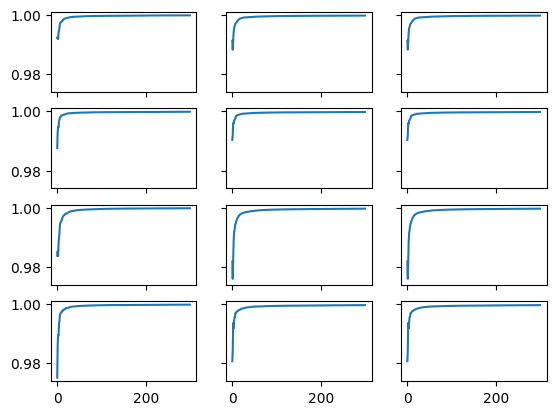

In [33]:
fig, axes = plt.subplots(4, 3, sharex=True, sharey=True)

for i, configs in tqdm(enumerate([dict(zip(def2vec_configs.keys(), values)) for  values in  product(*def2vec_configs.values())])):
    for j, suffix in tqdm(enumerate(['', '_reduced', '_extended'])):
        values = explained_variance[i][j]
        axes[i, j].plot(np.arange(len(values)), 1. - values)
plt.show()